In [1]:
import visualize as vs

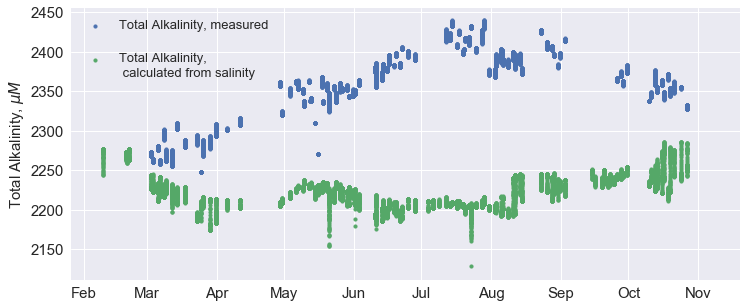

In [2]:
vs.plot_intro()

**Figure 1.** Surface water $\textrm{TA}$ measured and calculated from the alkalinity-salinity relation (Millero 1997), FerryBox measurements (54.19$^\circ$ N, 6.99$^\circ$ E, 2017)

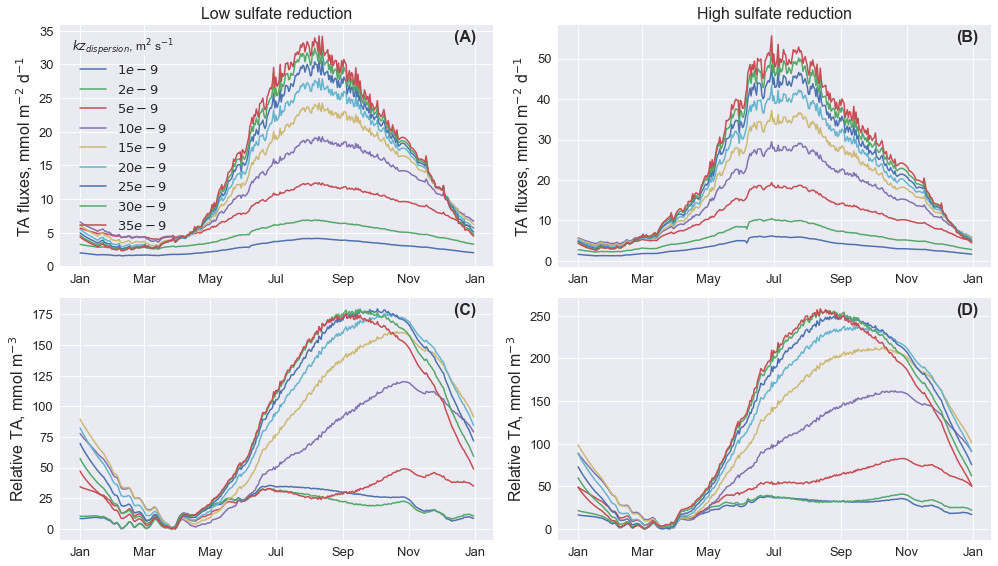

In [3]:
vs.plot_alkalinity_flux_low_high()

**Figure 2.** Yearly profiles of the $\textrm{TA}$ fluxes on the $\textrm{SWI}$ and the $\textrm{TA}$ increments (actual value minus yearly minimum value) in the surface layer for the different advection regimes with the average porosity of the top 10 cm of sediments $\phi \approx 0.43$

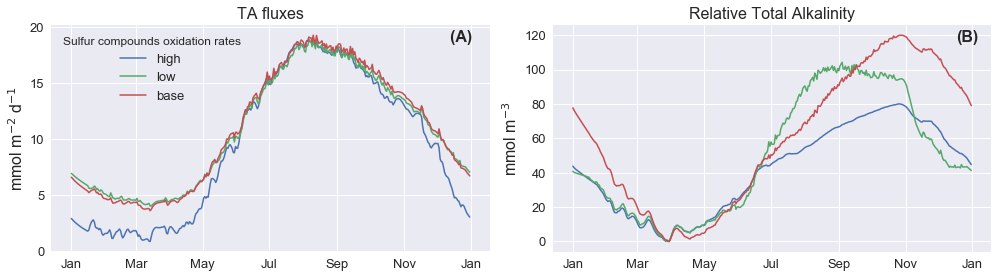

In [4]:
vs.plot_alkalinity_flux_sulfur_oxidation();

**Figure 3.** Yearly profiles of the $\textrm{TA}$ fluxes on the $\textrm{SWI}$ and $\textrm{TA}$ increments (actual value minus yearly minimum value) in the surface layer of the model for the different sulfur compounds oxidation rates with the lower bound of sulfate reduction rates, the average porosity of the top 10 cm of sediments $\phi \approx 0.43$, and $kz_{dispersion} = 10 \cdot 10^{-9}$ 

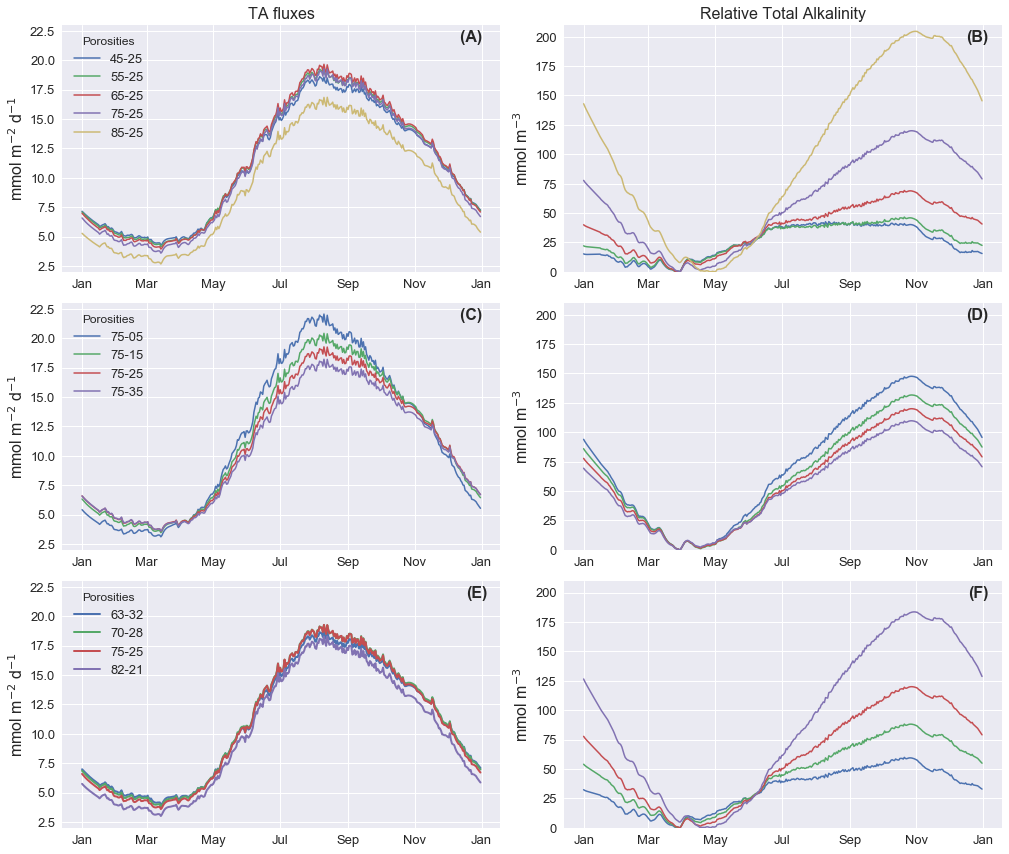

In [5]:
vs.plot_alkalinity_flux_porosities1_2_3()

**Figure 4.** Yearly profiles of the $\textrm{TA}$ fluxes on the $\textrm{SWI}$ and $\textrm{TA}$ increments (actual value minus yearly minimum value) in the surface layer of the model for the different porosities of the top 10 cm of sediments calculated with the lower bound of sulfate reduction rates and $kz_{dispersion} = 10 \cdot 10^{-9}$ 

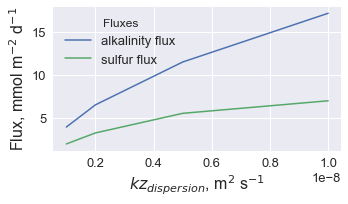

In [6]:
vs.plot_alk_sulfur_fluxes()

**Figure 5.** Average $\textrm{TA}$ and the reduced sulfur compounds fluxes on the $\textrm{SWI}$ in July with the lower bound of sulfate reduction rates for the different dispersion coefficients